In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.image as image

import numpy as np
import metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.cbook import get_test_data
from metpy.units import units
import os
import scipy.integrate as integrate
import datetime as dt
import glob
import json
from datetime import datetime
from datetime import timedelta
from metpy.plots import ctables
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

#import wrf
import scipy
#import xcape

In [4]:
file_dir = '/data/icond2/meteograms'

# Changing the directory
os.chdir(file_dir)

#data_uv = xr.open_dataset('arome_uv.nc').sel(longitude=slice(-1,12,1),latitude=slice(53,45,1))
data = xr.open_dataset('icond2_sfc.nc')

file_dir = '/data/icond2/meteograms'

# Changing the directory
os.chdir(file_dir)

# View a summary of the Dataset
print(data)


file_dir = '/home/lmathias/Documents/metpy/icond2'

# Changing the directory
os.chdir(file_dir)


im = image.imread('meteolux.jpg')
im2 = image.imread('dwd.png')


file_dir = '/data/icond2/meteograms'

# Changing the directory
os.chdir(file_dir)

<xarray.Dataset>
Dimensions:    (longitude: 1215, latitude: 746, time: 48)
Coordinates:
  * longitude  (longitude) float32 -3.94 -3.92 -3.9 -3.88 ... 20.3 20.32 20.34
  * latitude   (latitude) float32 43.18 43.2 43.22 43.24 ... 58.04 58.06 58.08
  * time       (time) datetime64[ns] 2023-01-10T04:00:00 ... 2023-01-12T03:00:00
Data variables:
    sde        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    r2         (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t          (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    gust       (time, latitude, longitude) float32 ...
    WW         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-10 04:43:32 GMT by grib_to_netcdf-2.22.1: gr

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitud

2023-01-10 03:00:00
2.9214704036712646


/tmp/ipykernel_13165/184351542.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


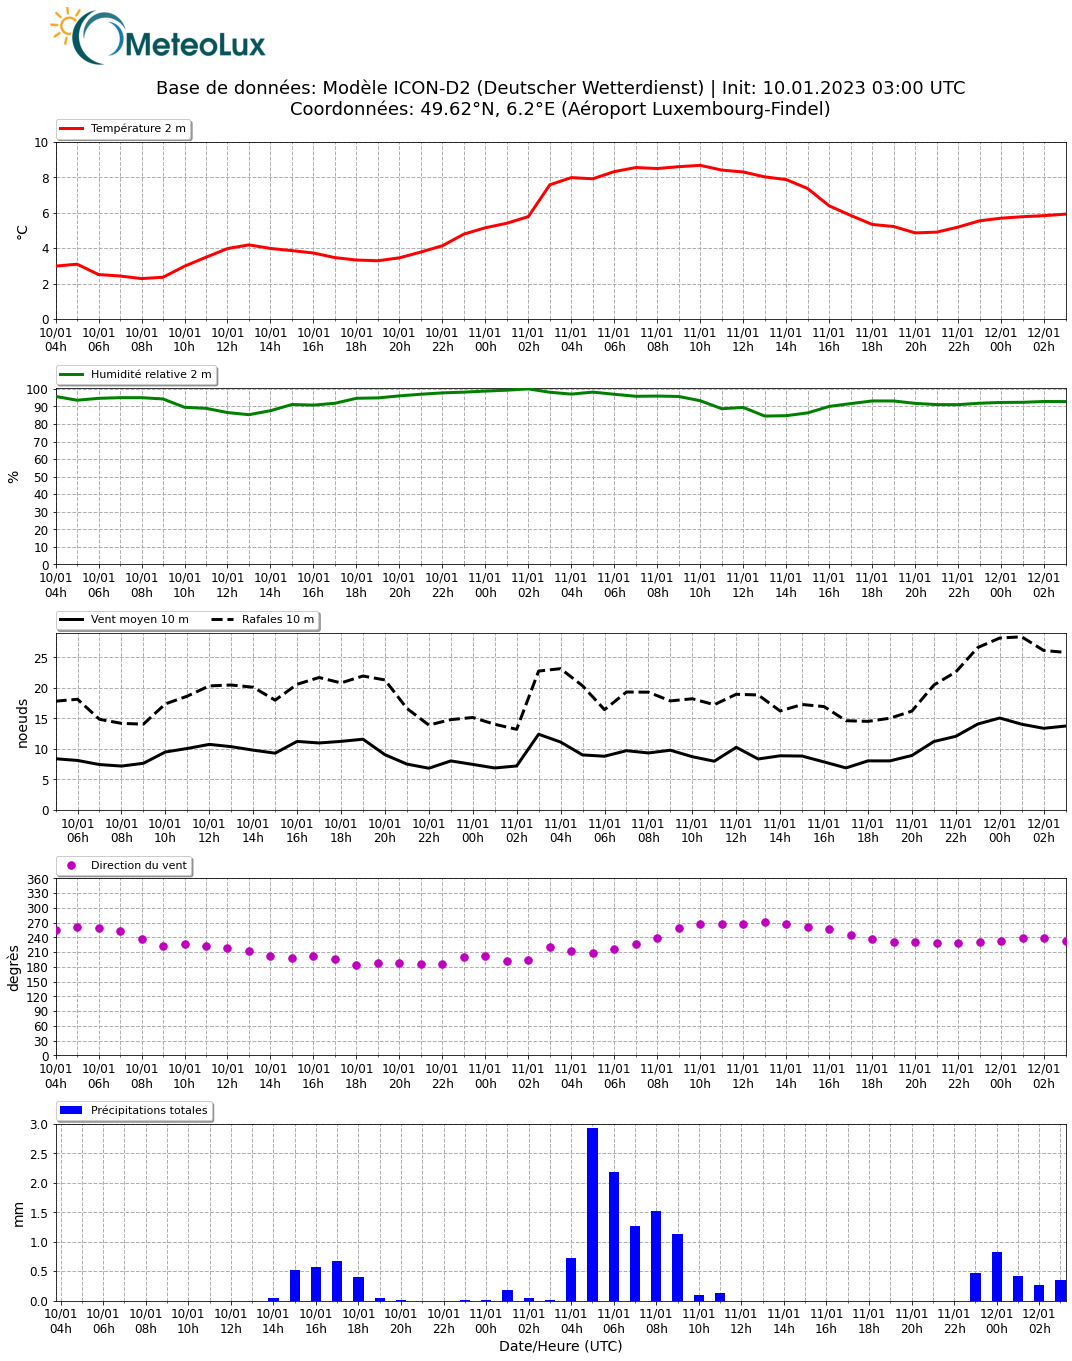

In [18]:
# To parse the full dataset, we can call parse_cf without an argument, and assign the returned Dataset.

data = data.metpy.parse_cf()

x, y = data['tp'].metpy.coordinates('x', 'y')

time = data['tp'].metpy.time

timeinit = time[0]
timeinit = datetime.utcfromtimestamp(timeinit.item()/1e9)- timedelta(hours=1)
print(timeinit)

lon = data['tp'].metpy.longitude
lat = data['tp'].metpy.latitude

dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
dx = dx[None, :]
dy = dy[None, :]

tp = data['tp']
#sp = data['unknown']
#msl = data['msl']
t = data['t2m']
r = data['r2']
u = data['u10']
fg = data['gust']
v = data['v10']

lat = 49.62
lon = 6.2
    
#msl = msl.metpy.loc[{'latitude': lat, 'longitude': lon}]/100   #convert to hPa
t = t.metpy.loc[{'latitude': lat, 'longitude': lon}]-273.15    #convert to °C
u = u.metpy.loc[{'latitude': lat, 'longitude': lon}]   
fg = fg.metpy.loc[{'latitude': lat, 'longitude': lon}]   
v = v.metpy.loc[{'latitude': lat, 'longitude': lon}]    
tp = tp.metpy.loc[{'latitude': lat, 'longitude': lon}]   
#sp = sp.metpy.loc[{'latitude': lat, 'longitude': lon}]  
r = r.metpy.loc[{'latitude': lat, 'longitude': lon}]  

dd = mpcalc.wind_direction(u*units('m/s'), v*units('m/s'), convention='from')
ff = mpcalc.wind_speed(u*units('m/s'), v*units('m/s'))
td = mpcalc.dewpoint_from_relative_humidity(t*units.degC,r)
#print(td.data.magnitude)

window = 24
average_data = []
for ind in range(len(t) - window + 1):
    average_data.append(np.mean(t[ind:ind+window]))
    
for ind in range(window - 1):
    average_data.insert(0, np.nan)

size = np.size(t)

plt.rcParams['axes.xmargin'] = 0

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d/%m\n%Hh')
loc = mdates.HourLocator(np.arange(0,24,2))
loc2 = mdates.HourLocator(np.arange(1,25,2))


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(15,18))
#ax1.plot(time[6:size], td[6:size], '-g', linewidth=3)
ax1.plot(time[0:size], t[0:size], '-r', linewidth=3,zorder=5)
ax1.set_ylabel('°C', fontsize=14)
#ax1.set_yticks(np.arange(np.round(np.min(t))-1, np.round(np.max(t))+1,1))
ax1.set_ylim(np.round(np.min(t)-2),np.round(np.max(t)+1))
ax1.xaxis.set_major_locator(loc)
ax1.xaxis.set_minor_locator(loc2)
ax1.xaxis.set_major_formatter(myFmt)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(['Température 2 m'],bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
         fancybox=True, shadow=True, borderaxespad=0, ncol=3, fontsize=11)
ax1.grid(which='both', linestyle='--', linewidth='1',zorder=1)

#ax2.plot(time[6:size], td[6:size], '-g', linewidth=3)
ax2.plot(time[0:size], r[0:size], '-g', linewidth=3,zorder=5)
ax2.set_ylabel('%', fontsize=14)
#ax2.set_yticks(np.arange(np.round(np.min(t))-1, np.round(np.max(t))+1,1))
ax2.set_yticks([0,10,20,30,40,50,60,70,80,90,100])
ax2.xaxis.set_major_locator(loc)
ax2.xaxis.set_minor_locator(loc2)
ax2.xaxis.set_major_formatter(myFmt)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(['Humidité relative 2 m'],bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                fancybox=True, shadow=True, borderaxespad=0, ncol=3, fontsize=11)
ax2.grid(which='both', linestyle='--', linewidth='1',zorder=1)

ax3.plot(time[1:size], ff[1:size]*1.94384 , '-k', linewidth=3,zorder=5)
ax3.plot(time[1:size], fg[1:size]*1.94384 , '--k', linewidth=3, zorder=5)
ax3.set_ylabel('noeuds', fontsize=14)
#ax3.set_yticks(np.arange(np.round(np.min(ff)), np.round(np.max(fg)),2))
ax3.set_ylim(0,np.round(np.max(fg*1.94384)+1))
ax3.xaxis.set_major_locator(loc)
ax3.xaxis.set_minor_locator(loc2)
ax3.xaxis.set_major_formatter(myFmt)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(['Vent moyen 10 m','Rafales 10 m'],bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                fancybox=True, shadow=True, borderaxespad=0, ncol=3, fontsize=11)
ax3.grid(which='both', linestyle='--', linewidth='1', zorder=1)

ax4.plot(time[0:size],dd[0:size], '.m', markersize=15, zorder=5)
ax4.set_ylabel('degrès', fontsize=14)
ax4.set_yticks([0,30,60,90,120,150,180,210,240,270,300,330,360])
ax4.xaxis.set_major_locator(loc)
ax4.xaxis.set_minor_locator(loc2)
ax4.xaxis.set_major_formatter(myFmt)
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.legend(['Direction du vent'],bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                fancybox=True, shadow=True, borderaxespad=0, ncol=3, fontsize=11)
ax4.grid(which='both', linestyle='--', linewidth='1', zorder=1)

rr = np.array(0)
for i in range(0,size):
    rr = np.append(rr, tp[i]-tp[i-1])
    ax5.bar(time[i], tp[i]-tp[i-1], width=0.02, color='b',zorder=5)
    #ax5.bar(time[i], sp[i]-sp[i-1], width=0.02, color='darkorange')
rr.astype(float)
print(np.nanmax(rr))
ax5.set_ylabel('mm', fontsize=14)
ax5.set_ylim(0,np.ceil(np.nanmax(rr)))
#ax5.set_yticks([0,1,2,3,4,5,6,7,8,9,10])
ax5.set_xlabel('Date/Heure (UTC)', fontsize=14)
ax5.xaxis.set_major_locator(loc)
ax5.xaxis.set_minor_locator(loc2)
ax5.xaxis.set_major_formatter(myFmt)
ax5.tick_params(axis='both', which='major', labelsize=12)
ax5.legend(['Précipitations totales'],bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                fancybox=True, shadow=True, borderaxespad=0, ncol=3, fontsize=11)
ax5.grid(which='both', linestyle='--', linewidth='1',zorder=1)

ax6 = fig.add_axes([0.05,0.9,0.20,0.25])
ax6.axis('off')
ax6.imshow(im, aspect='equal', origin='upper', zorder=6)
#ax7 = fig.add_axes([0.05,0.9,0.01,0.1])
#ax7.axis('off')
#ax7.imshow(im2, aspect='equal', origin='upper', zorder=6)

ax1.set_title(timeinit.strftime('Base de données: Modèle ICON-D2 (Deutscher Wetterdienst) | ' + timeinit.strftime('Init: %d.%m.%Y %H:%M UTC')+'\nCoordonnées: 49.62°N, 6.2°E (Aéroport Luxembourg-Findel)\n'), fontsize=18)

fig.tight_layout()

plt.savefig('icond2_luxairport.jpeg', format="jpeg", bbox_inches='tight', dpi=100)
plt.savefig('icond2_luxairport.pdf', format="pdf", bbox_inches='tight', dpi=100)

#np.max(t)

In [4]:
import pandas as pd

#pd.Series(t).rolling(window=24).mean().iloc[24-1:].values
pd.Series(r).rolling(window=24).mean().iloc[24-1:].values
#pd.Series(t).rolling(window=24).mean()

array([93.89554723, 93.95050303, 94.14310296, 94.23954423, 94.27254041,
       94.31102657, 94.36994394, 94.52547264, 94.5163606 , 94.63804436,
       94.60567093, 94.48721313, 94.28878371, 94.25725905, 94.24939219,
       94.18600368, 94.11282349, 93.93510882, 93.68908119, 93.4100008 ,
       93.14744663, 92.87815762, 92.59075737, 92.29215113, 92.07034683])